# Dog breed Identification

This is a attempt at a solution for the Kaggle Dog breed Identification.

https://www.kaggle.com/c/dog-breed-identification

### Description(As in Kaggle)

Who's a good dog? Who likes ear scratches? Well, it seems those fancy deep neural networks don't have all the answers. However, maybe they can answer that ubiquitous question we all ask when meeting a four-legged stranger: what kind of good pup is that?

In this playground competition, you are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

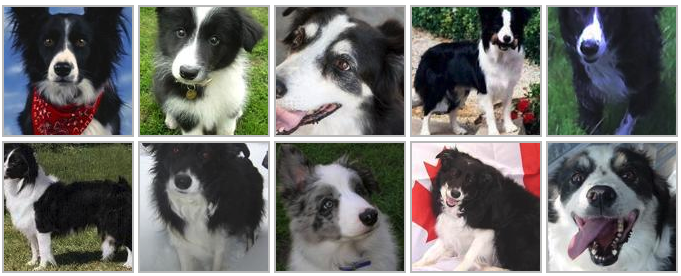

The datasets have been downloaded from the Kaggle site and are places in the same folder.

### Imports for importing datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, shutil
from tabulate import tabulate
%matplotlib inline

### Dataset folders

In [2]:
original_train_dir = 'train'
test_dir = 'test'

### Data Exploration

In [3]:
train_labels = np.array(pd.read_csv('labels.csv'))
classes, counts = np.unique(train_labels[:, 1], return_counts=True)

print("There are %d clases"%classes.size)

There are 120 clases


In [4]:
print(tabulate({"Dog Breeds":classes, "Count":counts},headers='keys'))

Dog Breeds                        Count
------------------------------  -------
affenpinscher                        80
afghan_hound                        116
african_hunting_dog                  86
airedale                            107
american_staffordshire_terrier       74
appenzeller                          78
australian_terrier                  102
basenji                             110
basset                               82
beagle                              105
bedlington_terrier                   89
bernese_mountain_dog                114
black-and-tan_coonhound              77
blenheim_spaniel                    102
bloodhound                           85
bluetick                             85
border_collie                        72
border_terrier                       91
borzoi                               75
boston_bull                          87
bouvier_des_flandres                 86
boxer                                75
brabancon_griffon                    67


### Plot of individual breed count

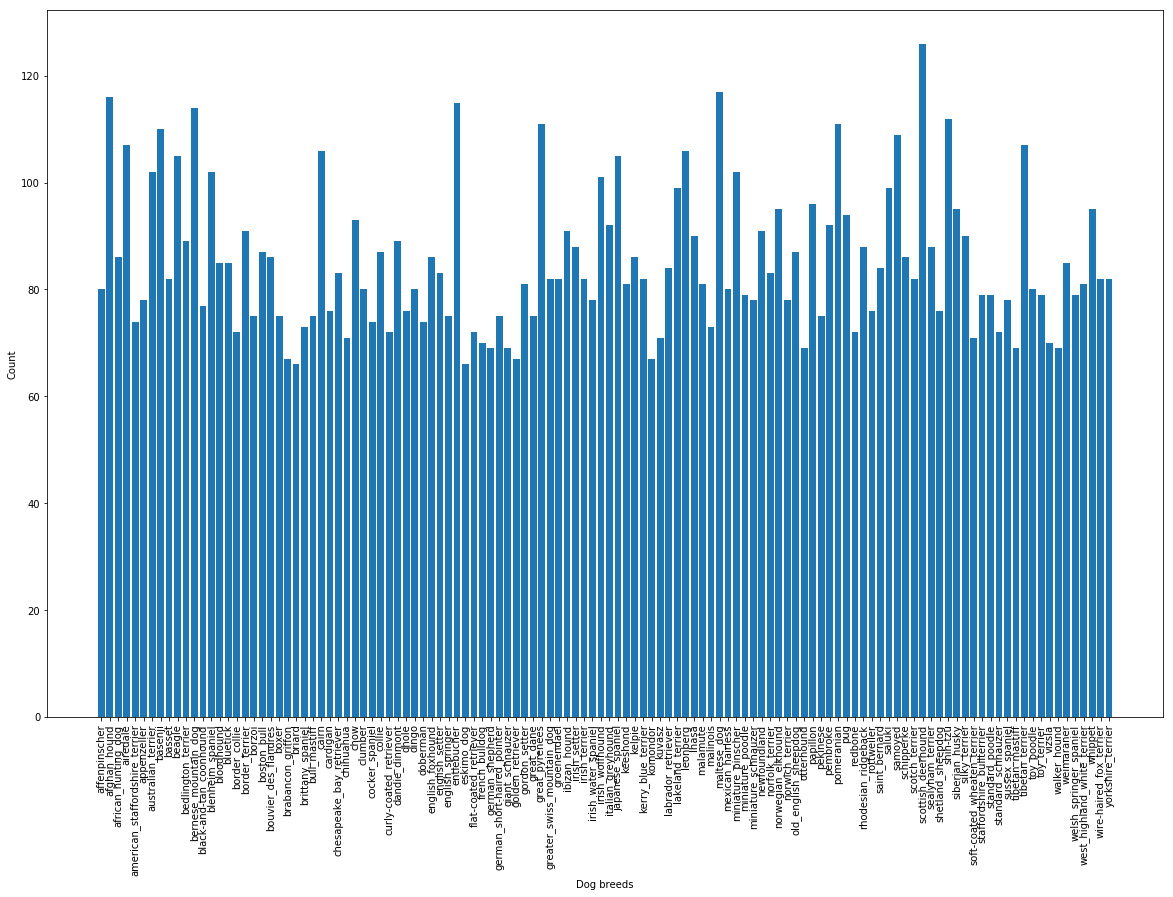

In [5]:
fig,ax = plt.subplots(1, figsize=(20,13))
ax.bar(classes, counts)
ax.set_xlabel("Dog breeds")
ax.set_ylabel("Count")
ax.set_xticklabels(classes,rotation='vertical')
plt.show()

### Helper functions

In [6]:
def mkdirIfNotExist(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)
    return directory

In [7]:
base_dir = mkdirIfNotExist('./data_gen')
train_dir = mkdirIfNotExist(os.path.join(base_dir, 'train'))
validation_dir = mkdirIfNotExist(os.path.join(base_dir, 'validation'))
test_dir = mkdirIfNotExist(os.path.join(base_dir, 'test'))

In [8]:
for c in classes[:]:
    mkdirIfNotExist(os.path.join(train_dir, c))
    mkdirIfNotExist(os.path.join(validation_dir, c))

In [9]:
def copyIfNotExist(fnames, src_dir, dst_dir):
    nCopied = 0
    for fname in fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)
            nCopied += 1
    if nCopied > 0:
        print("Copied %d to %s" % (nCopied, dst_dir))


### Creating train and validation folders for each dog breed

In [10]:
train_ratio = 0.7
for c in classes[:]:
    fnames = train_labels[train_labels[:, 1] == c][:, 0]
    fnames = ['{}.jpg'.format(name) for name in fnames]
    idx = int(len(fnames) * (1 - train_ratio))
    val_fnames = fnames[:idx]
    train_fnames = fnames[idx:]
    train_class_dir = os.path.join(train_dir, c)
    validation_class_dir = os.path.join(validation_dir, c)
    copyIfNotExist(train_fnames, original_train_dir, train_class_dir)
    copyIfNotExist(val_fnames, original_train_dir, validation_class_dir)


## Imports for image classification

Using tensorflow, keras. For transfer learning download weights for renowned models from the following link:

https://www.kaggle.com/gaborfodor/keras-pretrained-models/data


Download and paste the pretrained weights in ~/keras/models so that it can be directly loaded during training 

In [11]:
from sklearn.datasets import load_files       

from keras import applications
from keras.utils import np_utils
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image                  

from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True  

import pandas as pd
import numpy as np
import glob
import os

C:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
train_dir = 'data_gen/train'
val_dir = 'data_gen/validation'
test_dir = 'data/test'

In [13]:
# Testing preliminary steps and image dimensions 
img=image.load_img(r'train\000bec180eb18c7604dcecc8fe0dba07.jpg')
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
x.shape

(1, 375, 500, 3)

In [14]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [15]:
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [16]:
def generate_bottleneck_features_train():
    model = applications.ResNet50(include_top=False, weights='imagenet')

    train_files = load_files(train_dir)
    train_tensors = paths_to_tensor(train_files['filenames'])
    train_data = applications.resnet50.preprocess_input(train_tensors)
    train_files, train_tensors=None, None
        
    bottleneck_features_train = model.predict(
        train_data, batch_size=16)

    np.save('bottleneck_features/train.npy', bottleneck_features_train)
    bottleneck_features_train, train_data = None, None

In [17]:
def generate_bottleneck_features_validation():
    val_files = load_files(val_dir)
    val_tensors = paths_to_tensor(val_files['filenames'])
    val_data = applications.resnet50.preprocess_input(val_tensors)
    val_files, val_tensors=None, None
    
    bottleneck_features_validation = model.predict(
        val_data, batch_size=16)
    
    
    np.save('bottleneck_features/validation.npy', bottleneck_features_validation)
    bottleneck_features_validation, val_data = None, None

In [18]:
def generate_bottleneck_features_test():
    # build the network
    model = applications.ResNet50(include_top=False, weights='imagenet')

    files = glob.glob('test/*.jpg')
    tensors = paths_to_tensor(files)
    data = applications.resnet50.preprocess_input(tensors)
        
    bottleneck_features = model.predict(
        data, batch_size=16)
    
    np.save('bottleneck_features/test.npy', bottleneck_features)
    bottleneck_features, files, tensors= None, None, None

In [19]:
def load_labels(path):
    data = load_files(path)
    labels = np_utils.to_categorical(np.array(data['target']), 120)

    return labels

In [20]:
def extract_Resnet50(tensor):
    return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [21]:
# Comment these lines if you have already created the bottleneck features
## Create bottleneck features
#generate_bottleneck_features_train()

#generate_bottleneck_features_validation()

In [22]:
print('Loading training bottleneck features')
train_data = np.load('bottleneck_features/train.npy')
train_labels = load_labels('data_gen/train')

print('Loading validation bottleneck features')
validation_data = np.load('bottleneck_features/validation.npy')
validation_labels = load_labels('data_gen/validation')

Loading training bottleneck features
Loading validation bottleneck features


### Fine tuning the top layer of the model

In [23]:
print('Defining model')
model = Sequential()
model.add(Flatten(input_shape = train_data.shape[1:]))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))

Defining model


### Model summary

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

In [25]:
# compliling model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


# creating checkpointer
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=2, save_best_only=True)

In [26]:
## Hyper parameters

epochs = 40
batch_size = 64
history = model.fit(train_data, train_labels,
                    validation_data=(validation_data, validation_labels),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[checkpointer], verbose=2)

Train on 7213 samples, validate on 3009 samples
Epoch 1/40

Epoch 00001: val_loss improved from inf to 3.22210, saving model to saved_models/weights.best.hdf5
 - 20s - loss: 4.8949 - acc: 0.0417 - val_loss: 3.2221 - val_acc: 0.3579
Epoch 2/40

Epoch 00002: val_loss improved from 3.22210 to 2.14686, saving model to saved_models/weights.best.hdf5
 - 3s - loss: 3.5730 - acc: 0.1788 - val_loss: 2.1469 - val_acc: 0.5341
Epoch 3/40

Epoch 00003: val_loss improved from 2.14686 to 1.61206, saving model to saved_models/weights.best.hdf5
 - 3s - loss: 2.7582 - acc: 0.3160 - val_loss: 1.6121 - val_acc: 0.6261
Epoch 4/40

Epoch 00004: val_loss improved from 1.61206 to 1.32820, saving model to saved_models/weights.best.hdf5
 - 3s - loss: 2.3048 - acc: 0.3989 - val_loss: 1.3282 - val_acc: 0.6733
Epoch 5/40

Epoch 00005: val_loss improved from 1.32820 to 1.17591, saving model to saved_models/weights.best.hdf5
 - 3s - loss: 2.0100 - acc: 0.4567 - val_loss: 1.1759 - val_acc: 0.6846
Epoch 6/40

Epoch 00

In [27]:
## Testing

model.load_weights('saved_models/weights.best.hdf5')

train_labels = np.array(pd.read_csv('labels.csv'))
classes, counts = np.unique(train_labels[:, 1], return_counts=True)

## Creating headers for output file
f = open('results.csv', 'w')
f.write('id')
for c in classes:
    f.write(',' + c)
f.write('\n')

1

In [28]:
## Comment if bottleneck features are already generated

#generate_bottleneck_features_test()

In [29]:
test = np.load('bottleneck_features/test.npy')

In [30]:
## Predicting on the test set
output = model.predict(test)

In [31]:
##Saving results to csv

filenames = os.listdir('test')
for [o, name] in zip(output, filenames):
    f.write(name[:-4] + ',')
    o.tofile(f, sep=',', format='%.17f')
    f.write('\n')

f.close()